# Imports


In [32]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from path_explain import PathExplainerTF, scatter_plot, summary_plot, softplus_activation
from path_explain.utils import set_up_environment
from sklearn.metrics import r2_score


In [33]:
set_up_environment(visible_devices='3')


# Loading the Data


In [34]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()


In [35]:
scaler = StandardScaler()


In [36]:
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Training the Model


In [37]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(13,)))
model.add(tf.keras.layers.Dense(
    units=32, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(
    units=32, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1,  activation=None))

optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.9, nesterov=True)
loss = tf.keras.losses.MeanSquaredError()
metrics = [tf.keras.metrics.MeanSquaredError(
), tf.keras.metrics.MeanAbsoluteError()]
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.fit(x_train_scaled, y_train, batch_size=64, epochs=50, verbose=0)
train_loss, train_mse, train_mae = model.evaluate(
    x_train_scaled, y_train, batch_size=64, verbose=0)
test_loss, test_mse, test_mae = model.evaluate(
    x_test_scaled, y_test, batch_size=64, verbose=0)

In [38]:
print('Train MSE: {:.4f}\tTrain MAE: {:.4f}'.format(train_mse, train_mae))
print('Test MSE: {:.4f}\tTest MAE: {:.4f}'.format(test_mse, test_mae))


Train MSE: 5.7013	Train MAE: 1.6774
Test MSE: 17.3476	Test MAE: 2.6089


4/4 [==============================] - 0s 1ms/step


(102,)
(102,)
R2 score: 0.7916


<Axes: >

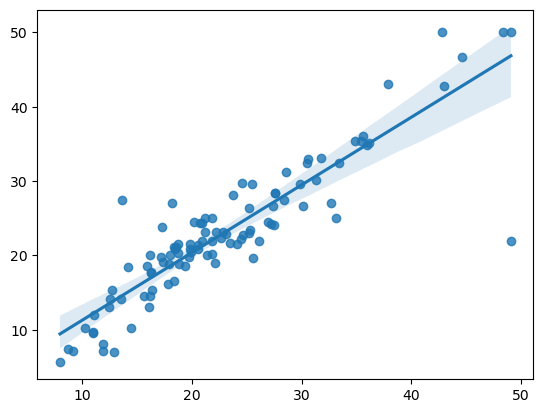

In [39]:
y_pred = model.predict(x_test_scaled)

print(y_pred[:, 0].shape)
print(y_test.shape)
r2 = r2_score(y_test, y_pred[:, 0])
print(f"R2 score: {r2:.4f}")

sns.regplot(x=y_pred[:, 0], y=y_test)

# Interpreting the Model


The first step in interpreting a ReLU-based model is changing the activations to softplus. The justification for doing this is discussed in the original paper, but in code this is fairly simple to do. First we clone the model, and then we manually change the activation function!


In [40]:
# Clone the model
interpret_model = tf.keras.models.clone_model(model)
interpret_model.set_weights(model.get_weights())

# Loop through layers to change activation functions
for layer in interpret_model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = softplus_activation(beta=10.0)


4/4 [==============================] - 0s 1ms/step


(102,)
(102,)
R2 score: 0.7931


<Axes: >

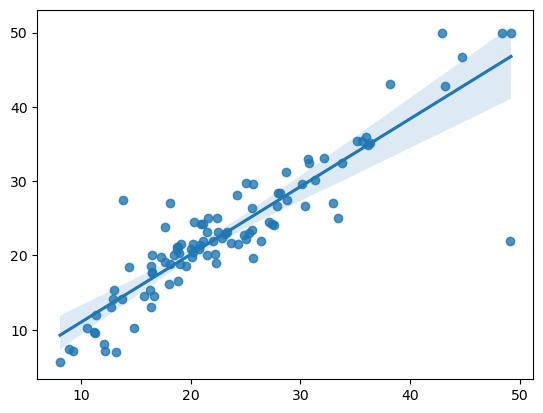

In [41]:
y_pred = interpret_model.predict(x_test_scaled)

print(y_pred[:, 0].shape)
print(y_test.shape)
r2 = r2_score(y_test, y_pred[:, 0])
print(f"R2 score: {r2:.4f}")

sns.regplot(x=y_pred[:, 0], y=y_test)

The next step is to define our explainer object.


In [42]:
# Taken from https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
                 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
print(x_test_scaled.shape)
print(x_train_scaled.shape)


(102, 13)
(404, 13)


Now we actually have to run the attribution function. Here we used expected gradients because the argument `use_expectation` is equal to true and the baseline is set to be the training data. However, we could set `use_expectation` and the baseline to be the zeros vector to use integrated gradients instead.


In [43]:
explainer = PathExplainerTF(interpret_model)
attributions = explainer.attributions(inputs=x_test_scaled.astype(np.float32),
                                      baseline=x_train_scaled.astype(
                                          np.float32),
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

  7%|▋         | 7/102 [00:00<00:01, 62.60it/s]

100%|██████████| 102/102 [00:01<00:00, 65.11it/s]


(102, 13)
(102, 13)


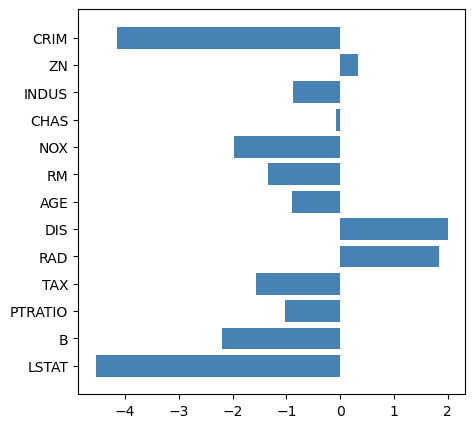

In [44]:
print(x_test_scaled.shape)
print(attributions.shape)

# Organize the calculated SHAP values and their corresponding feature names into a DataFrame.
attributions_df = pd.DataFrame(
    data={'attributions value': attributions[0, :], 'feature': feature_names[:-1]})
# display(attributions_df)

# # Order the DataFrame based on the SHAP values to understand which features have the greatest influence.
# shap_df = shap_df.sort_values(by='SHAP Value', ascending=False)

# # Visualize the mean absolute SHAP values using a horizontal bar chart.
# # This provides a quick view of the relative importance of each feature.
plt.figure(figsize=(5, 5))
plt.barh(y=attributions_df['feature'],
         width=attributions_df['attributions value'], color='steelblue')
# plt.xlabel('Mean Absolute SHAP Value')
# plt.title('Feature Importance')
plt.gca().invert_yaxis()

The code to generate interactions takes the same arguments as the code to generate attributions. This makes generating interactions nice and easy! Here we are using expected hessians to generate interactions, but we can also use integrated hessians by changing the same arguments mentioned above.


In [45]:
interactions = explainer.interactions(inputs=x_test_scaled.astype(np.float32),
                                      baseline=x_train_scaled.astype(
                                          np.float32),
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

  0%|          | 0/102 [00:00<?, ?it/s]

100%|██████████| 102/102 [03:05<00:00,  1.82s/it]


In [1]:
print(interactions.shape)
print(interactions[0].shape)

average_interactions = np.mean(interactions, axis=0)
print(average_interactions.shape)

# Create a mask with True in all the cells. We'll only set the diagonal to False in the next step.
mask = np.triu(np.ones_like(average_interactions, dtype=bool))

# Set the diagonal to False (these are the cells we want to keep)
np.fill_diagonal(mask, False)

ax = sns.heatmap(interactions[0, :, :], mask=mask, annot=False, fmt=".2f", cmap='RdBu_r', vmax=4.0, vmin=-4.0,
                 xticklabels=feature_names[:-1], yticklabels=feature_names[:-1])
ax.tick_params(axis='x', labelrotation=45)
plt.title("Correlation matrix of the features")


NameError: name 'interactions' is not defined

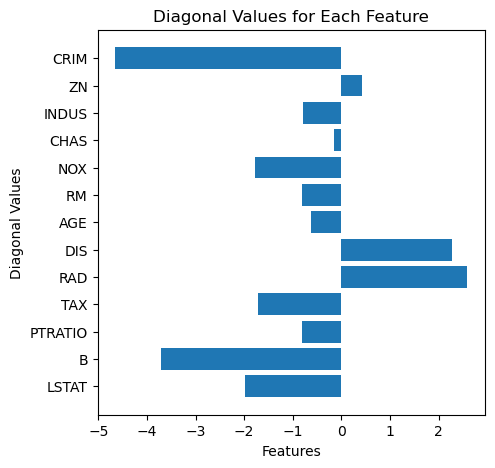

In [47]:
# Extract diagonal values
diagonal_values = np.diag(interactions[0, :, :])

# Get feature names. You already have feature_names from your existing code
# Make sure it has the same length as the diagonal
assert len(feature_names[:-1]) == len(diagonal_values)

# Plotting the bar chart
plt.figure(figsize=(5, 5))
plt.barh(feature_names[:-1], diagonal_values)
plt.xlabel('Features')
plt.ylabel('Diagonal Values')
plt.title('Diagonal Values for Each Feature')
plt.gca().invert_yaxis()

plt.show()

In [48]:
interactions.shape

(102, 13, 13)

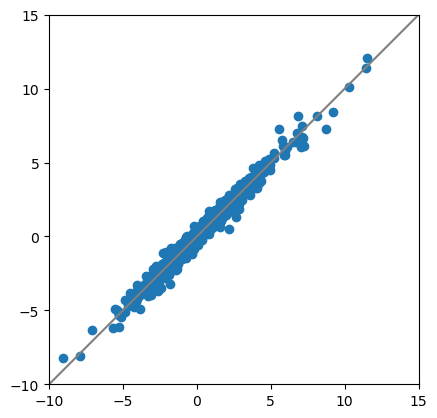

In [49]:
fig, ax = plt.subplots()
ax.scatter(x=np.reshape(attributions, -1),
           y=np.reshape(np.sum(interactions, axis=-1), -1))
ax.set(xlim=[-10, 15], ylim=[-10, 15], aspect='equal', box_aspect=1)
ax.plot([-10, 15], [-10, 15], color='grey')
plt.show()


First, we do a summary plot of all the attributions. To give credit where credit is due, most of the plotting libraries here are based off of the [SHAP package](https://github.com/slundberg/shap). Thanks Scott :)


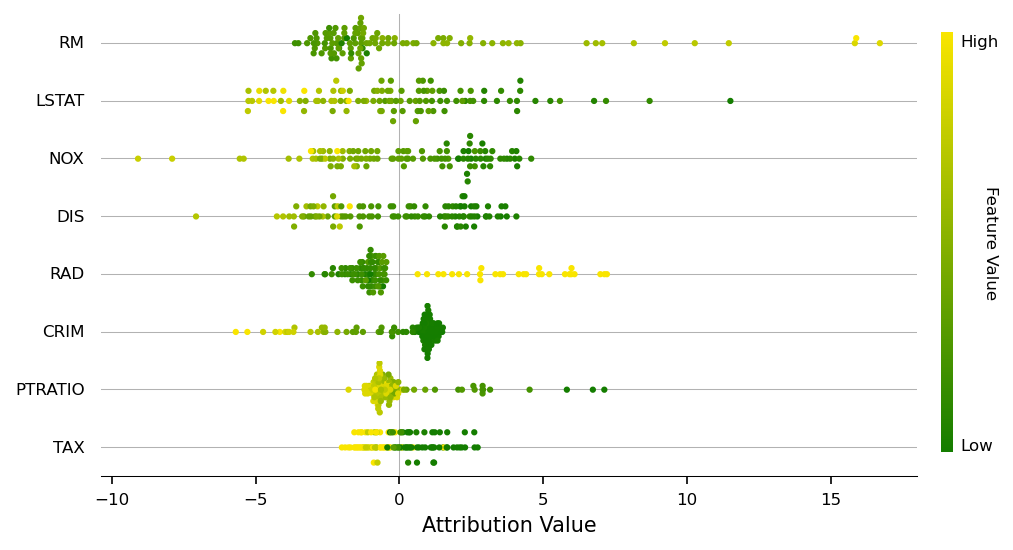

In [50]:
summary_plot(attributions,
             x_test,
             feature_names=feature_names,
             plot_top_k=8)


Next, we plot the attributions and interactions of a specific feature. We can see some interesting patterns that our model has learned!


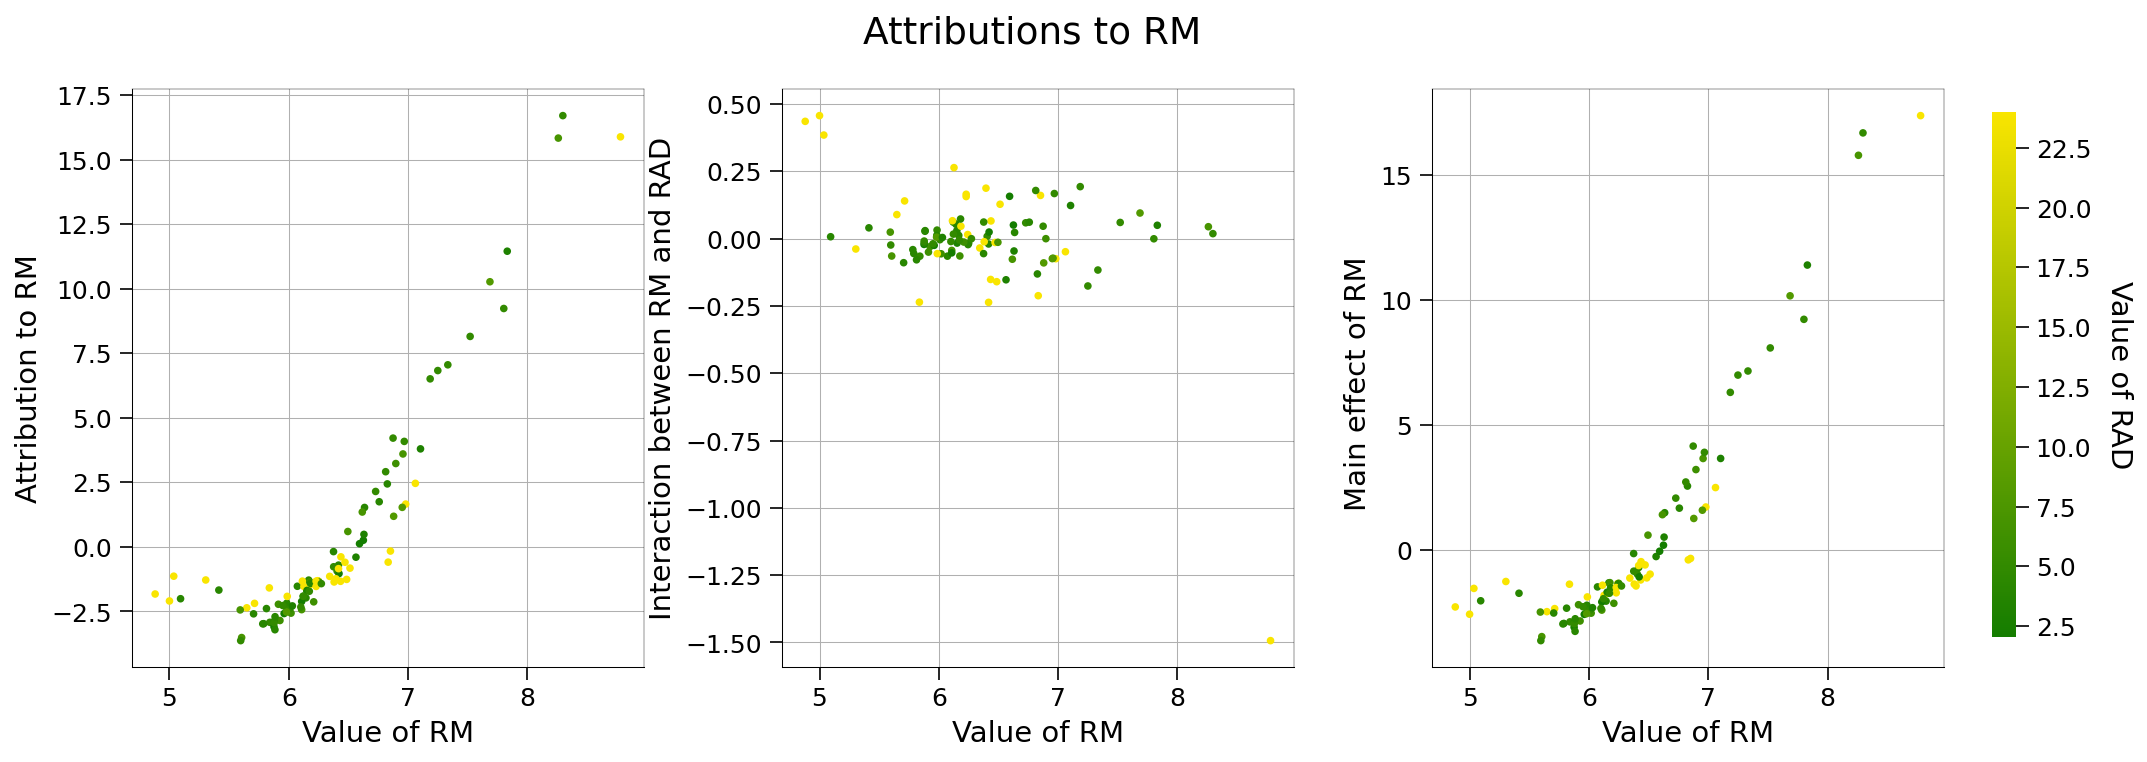

In [51]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index='RM',
                        interactions=interactions,
                        color_by='RAD',
                        feature_names=feature_names,
                        scale_y_ind=True)
